# Handwritten Text Recognition (PyTorch, Colab-ready)
Lean, end-to-end notebook for IAM word-level HTR with CTC, augmentations, and greedy decoding.


In [2]:
# Install required packages
%pip install -q numpy matplotlib pillow scikit-learn torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import os
import math
import random
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


In [4]:
# Settings & hyperparameters
IMAGE_SIZE = (160, 48)  # (width, height)
BATCH_SIZE = 48        # smaller batch for bigger images
EPOCHS = 80            # train longer; still fast enough
LEARNING_RATE = 1e-3   # peak LR for OneCycle
PAD_TOKEN = 99
BLANK_TOKEN = 0  # for CTC loss
SEED = 43

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)



Using device: cuda


In [5]:
# Install + download IAM via kagglehub (Colab-friendly)
%pip install -q kagglehub

import kagglehub

# Set your Kaggle token (for Colab you can paste your token string or use /root/.kaggle/kaggle.json)
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_be9c382f7d5391aa23404b90f2c252cb'

try:
    print("Attempting to download dataset...")
    iam_root = Path(kagglehub.dataset_download("nibinv23/iam-handwriting-word-database"))
    print(f"Dataset downloaded to: {iam_root}")
except Exception as e:
    print(f"Download skipped/failed: {e}")
    print("Ensure KAGGLE_API_TOKEN is correct or upload ~/.kaggle/kaggle.json")
    iam_root = Path("/kaggle/input/iam-handwriting-word-database")  # fallback for Kaggle runtimes

DATA_INPUT_PATH = iam_root


Note: you may need to restart the kernel to use updated packages.
Attempting to download dataset...


/home/grant/GrantProjects/Handwriting/handwritingFinal/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: /home/grant/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2


## Quick peek at a few samples (optional)
Visual sanity check; skip if you trust the paths.


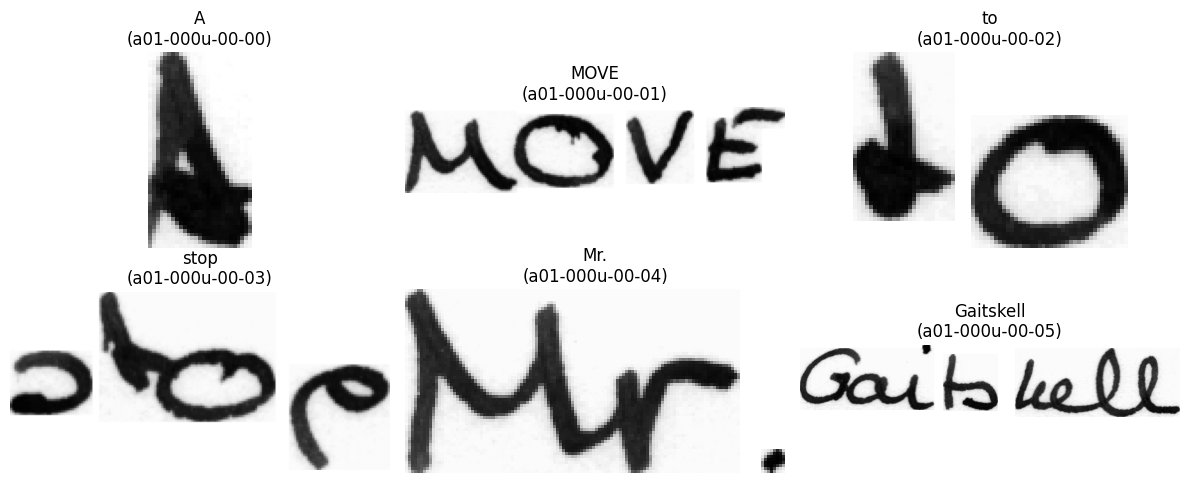

In [6]:
def show_first_six_images(root_dir: Path):
    words_files = list(root_dir.rglob('words.txt'))
    if not words_files:
        print("words.txt not found.")
        return
    words_path = words_files[0]
    a01_dirs = list(root_dir.rglob('a01'))
    if not a01_dirs:
        print("Could not find image directory 'a01'.")
        return
    img_root = a01_dirs[0].parent

    count = 0
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    axes = axes.flatten()
    with open(words_path, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            parts = line.strip().split()
            word_id = parts[0]
            transcription = parts[-1]
            id_parts = word_id.split('-')
            folder1 = id_parts[0]
            folder2 = f"{id_parts[0]}-{id_parts[1]}"
            img_path = img_root / folder1 / folder2 / f"{word_id}.png"
            if img_path.exists():
                try:
                    img = Image.open(img_path).convert("L")
                    ax = axes[count]
                    ax.imshow(img, cmap="gray")
                    ax.set_title(f"{transcription}\n({word_id})")
                    ax.axis('off')
                    count += 1
                except Exception:
                    pass
            if count >= 6:
                break
    plt.tight_layout()
    plt.show()

show_first_six_images(DATA_INPUT_PATH)



## Parse IAM metadata and build charset


In [7]:
labels = []
images_path = []

words_file = DATA_INPUT_PATH / "iam_words" / "words.txt"
assert words_file.exists(), f"Missing words.txt at {words_file}"

characters = set()
max_len = 0
with words_file.open("r") as f:
    for line in f:
        if line.startswith("#") or not line.strip():
            continue
        parts = line.strip().split()
        word_id = parts[0]
        label = parts[-1]

        first_folder = word_id.split("-")[0]
        second_folder = f"{first_folder}-{word_id.split('-')[1]}"
        image_filename = f"{word_id}.png"
        image_path = DATA_INPUT_PATH / "iam_words" / "words" / first_folder / second_folder / image_filename
        if image_path.is_file() and image_path.stat().st_size > 0:
            images_path.append(str(image_path))
            labels.append(label)
            characters.update(label)
            max_len = max(max_len, len(label))

characters = sorted(list(characters))
print(f"Total samples: {len(images_path)} | Max label len: {max_len}")
print(f"Charset size: {len(characters)} -> {characters[:20]}{' ...' if len(characters) > 20 else ''}")

# Build lookup tables (0 reserved for blank)
char_to_idx = {c: i + 1 for i, c in enumerate(characters)}
idx_to_char = {i + 1: c for i, c in enumerate(characters)}
num_classes = len(characters) + 1
print(f"num_classes (incl. blank): {num_classes}")


Total samples: 44563 | Max label len: 19
Charset size: 76 -> ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8'] ...
num_classes (incl. blank): 77


## Augmentations and preprocess transforms
Stronger geometry + noise to improve robustness; val/test stay clean.


In [8]:
class RandomGaussianBlur:
    def __init__(self, p=0.2, radius=(0.1, 1.2)):
        self.p = p
        self.radius = radius

    def __call__(self, img: Image.Image):
        if random.random() > self.p:
            return img
        r = random.uniform(self.radius[0], self.radius[1])
        return img.filter(ImageFilter.GaussianBlur(radius=r))


class AddGaussianNoise:
    def __init__(self, p=0.25, sigma=(0.0, 0.08)):
        self.p = p
        self.sigma = sigma

    def __call__(self, x: torch.Tensor):
        if random.random() > self.p:
            return x
        s = random.uniform(self.sigma[0], self.sigma[1])
        return (x + torch.randn_like(x) * s).clamp(-1.0, 1.0)


def build_transforms(image_size_wh):
    w, h = image_size_wh  # (W, H)
    train_tf = T.Compose([
        T.Grayscale(num_output_channels=1),
        T.Resize((h, w)),
        T.RandomApply([T.RandomAffine(
            degrees=12,
            translate=(0.08, 0.14),
            scale=(0.82, 1.18),
            shear=(-12, 12),
            interpolation=T.InterpolationMode.BILINEAR,
            fill=255,
        )], p=0.85),
        T.RandomApply([T.RandomPerspective(distortion_scale=0.22, p=1.0)], p=0.35),
        T.RandomApply([RandomGaussianBlur(p=1.0)], p=0.30),
        T.RandomApply([T.ColorJitter(brightness=0.30, contrast=0.40)], p=0.70),
        T.RandomApply([T.RandomAdjustSharpness(sharpness_factor=1.5)], p=0.30),
        T.RandomApply([T.RandomAutocontrast()], p=0.15),
        T.RandomRotation(degrees=3, fill=255),
        T.ToTensor(),
        T.Normalize([0.5], [0.5]),
        AddGaussianNoise(p=0.35, sigma=(0.0, 0.07)),
        T.RandomErasing(p=0.25, scale=(0.01, 0.06), ratio=(0.2, 5.0), value=1.0),
    ])

    val_tf = T.Compose([
        T.Grayscale(num_output_channels=1),
        T.Resize((h, w)),
        T.ToTensor(),
        T.Normalize([0.5], [0.5]),
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms(IMAGE_SIZE)



## Dataset + collate


In [9]:
class IAMWordDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        target = torch.tensor([char_to_idx[c] for c in label], dtype=torch.long)
        return img, target


def collate_batch(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    target_lengths = torch.tensor([t.size(0) for t in targets], dtype=torch.long)
    targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=PAD_TOKEN)
    return images, targets_padded, target_lengths


## Split + DataLoaders


In [10]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images_path, labels, test_size=0.2, random_state=SEED, stratify=None
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    test_imgs, test_labels, test_size=0.5, random_state=SEED, stratify=None
)

train_ds = IAMWordDataset(train_imgs, train_labels, transform=train_tf)
val_ds = IAMWordDataset(val_imgs, val_labels, transform=val_tf)
test_ds = IAMWordDataset(test_imgs, test_labels, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_batch)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_batch)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train: 35650 | Val: 4456 | Test: 4457


## Model: CNN + BiLSTM + CTC


In [11]:
class HTRModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.15),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        rnn_input_size = 128 * (IMAGE_SIZE[1] // 8)
        self.lstm1 = nn.LSTM(rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)
        self.lstm_dropout = nn.Dropout(0.2)
        self.head_dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()  # [B, W, C, H]
        x = x.view(b, w, c * h)                 # [B, W, C*H]
        x, _ = self.lstm1(x)
        x = self.lstm_dropout(x)
        x, _ = self.lstm2(x)
        x = self.lstm_dropout(x)
        x = self.head_dropout(x)
        x = self.classifier(x)
        x = x.log_softmax(2)
        return x

model = HTRModel(num_classes=num_classes).to(DEVICE)
print(model)



HTRModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout2d(p=0.15, inplace=False)
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(768, 256, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 128, batch_first=True, bidirectional=True)
  (lstm_dropout): Dropout(p=0.2, inplace=False)
  (head_dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=256,

## Training helpers (CTC, decoding, CER)


In [12]:
ctc_loss_fn = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)


def greedy_decode(log_probs, input_lengths):
    max_probs = log_probs.detach().cpu().argmax(2)
    decoded = []
    for seq, seq_len in zip(max_probs, input_lengths):
        prev = None
        chars = []
        for idx in seq[:seq_len]:
            idx = idx.item()
            if idx == BLANK_TOKEN:
                prev = None
                continue
            if idx != prev:
                chars.append(idx_to_char.get(idx, ""))
            prev = idx
        decoded.append("".join(chars))
    return decoded


def levenshtein(a, b):
    m, n = len(a), len(b)
    if m == 0:
        return n
    if n == 0:
        return m
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    return dp[m][n]


def cer(preds, targets):
    total_dist, total_len = 0, 0
    for p, t in zip(preds, targets):
        total_dist += levenshtein(p, t)
        total_len += len(t)
    return total_dist / max(total_len, 1)


def flatten_targets(targets, lengths):
    pieces = []
    for tgt, l in zip(targets, lengths):
        pieces.append(tgt[:l])
    return torch.cat(pieces)


def train_one_epoch(model, loader, optimizer, scaler=None, scheduler=None, grad_clip=5.0, use_amp=True, log_every=None):
    model.train()
    total_loss = 0.0
    log_every = log_every or max(1, len(loader) // 5)

    for batch_idx, (images, targets, target_lengths) in enumerate(loader, 1):
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)
        target_lengths = target_lengths.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            log_probs = model(images)
            T_len = log_probs.size(1)
            input_lengths = torch.full((log_probs.size(0),), T_len, dtype=torch.long, device=DEVICE)
            log_probs_ctc = log_probs.permute(1, 0, 2)
            targets_flat = flatten_targets(targets, target_lengths)
            loss = ctc_loss_fn(log_probs_ctc, targets_flat, input_lengths, target_lengths)

        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

        total_loss += loss.item() * images.size(0)

        if batch_idx % log_every == 0 or batch_idx == len(loader):
            running = total_loss / (batch_idx * loader.batch_size)
            lr_now = optimizer.param_groups[0]["lr"]
            print(f"  batch {batch_idx:>4}/{len(loader)} | running loss {running:.4f} | lr {lr_now:.2e}")
    return total_loss / len(loader.dataset)


def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, targets, target_lengths in loader:
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)
            target_lengths = target_lengths.to(DEVICE, non_blocking=True)

            log_probs = model(images)
            T_len = log_probs.size(1)
            input_lengths = torch.full((log_probs.size(0),), T_len, dtype=torch.long, device=DEVICE)
            log_probs_ctc = log_probs.permute(1, 0, 2)
            targets_flat = flatten_targets(targets, target_lengths)

            loss = ctc_loss_fn(log_probs_ctc, targets_flat, input_lengths, target_lengths)
            total_loss += loss.item() * images.size(0)

            preds_text = greedy_decode(log_probs, input_lengths)
            labels_text = ["".join(idx_to_char.get(int(c), "") for c in tgt[:l]) for tgt, l in zip(targets, target_lengths)]
            all_preds.extend(preds_text)
            all_labels.extend(labels_text)
    avg_loss = total_loss / len(loader.dataset)
    cer_score = cer(all_preds, all_labels)
    return avg_loss, cer_score



## Optimizer, scheduler, AMP


In [13]:
use_amp = torch.cuda.is_available()  # AMP only on CUDA here for compatibility
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
use_onecycle = True  # warmup + cosine decay
if use_onecycle:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        total_steps=EPOCHS * len(train_loader),
        pct_start=0.10,
        anneal_strategy="cos",
        div_factor=10.0,      # start at max_lr / div_factor
        final_div_factor=100.0,
    )
else:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3,
        threshold=1e-3,
        min_lr=1e-5,
    )

# quick sanity check on a tiny batch (no training)
with torch.no_grad():
    images, targets, target_lengths = next(iter(train_loader))
    logits = model(images.to(DEVICE))
    print("Time steps from model:", logits.size(1))


/tmp/ipykernel_37525/1886219864.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Time steps from model: 40


## Train loop with early stopping + checkpoint


In [ ]:
history = {"train_loss": [], "val_loss": [], "val_cer": []}
best = {"cer": float("inf"), "epoch": 0}
patience = 8
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch:02d} starting...")
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        scaler=scaler,
        scheduler=scheduler if use_onecycle else None,
        grad_clip=5.0,
        use_amp=use_amp,
    )
    val_loss, val_cer = eval_one_epoch(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_cer"].append(val_cer)

    print(f"Epoch {epoch:02d} done | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_CER={val_cer:.4f}")

    if scheduler is not None and not use_onecycle:
        scheduler.step(val_cer)

    if val_cer < best["cer"] - 1e-4:
        best = {"cer": val_cer, "epoch": epoch}
        no_improve = 0
        if 'save_model_complete' in globals():
            save_model_complete(model, optimizer, epoch, val_cer, save_dir="checkpoints", model_name="htr_model")
        else:
            # fallback: minimal checkpoint
            Path("checkpoints").mkdir(parents=True, exist_ok=True)
            torch.save({"epoch": epoch, "model": model.state_dict(), "optimizer": optimizer.state_dict()}, Path("checkpoints/htr_model_best.pt"))
        print(f"  ✓ new best CER: {val_cer:.4f} (saved)")
    else:
        no_improve += 1
        print(f"  no improve ({no_improve}/{patience}) | best={best['cer']:.4f} @ epoch {best['epoch']}")

    if no_improve >= patience:
        print("Stopping early: CER plateau")
        break


Epoch 01 starting...
  batch  148/743 | running loss 15.0611 | lr 1.01e-04
  batch  296/743 | running loss 9.5451 | lr 1.05e-04
  batch  444/743 | running loss 7.6793 | lr 1.12e-04
  batch  592/743 | running loss 6.7264 | lr 1.22e-04
  batch  740/743 | running loss 6.1195 | lr 1.34e-04
  batch  743/743 | running loss 6.1083 | lr 1.34e-04
Epoch 01 done | train_loss=6.1107 | val_loss=3.5456 | val_CER=1.0000
  ✓ new best CER: 1.0000 (saved)
Epoch 02 starting...
  batch  148/743 | running loss 3.5639 | lr 1.49e-04
  batch  296/743 | running loss 3.5266 | lr 1.66e-04
  batch  444/743 | running loss 3.4925 | lr 1.86e-04
  batch  592/743 | running loss 3.4629 | lr 2.07e-04
  batch  740/743 | running loss 3.4328 | lr 2.31e-04
  batch  743/743 | running loss 3.4307 | lr 2.32e-04
Epoch 02 done | train_loss=3.4321 | val_loss=3.1772 | val_CER=0.9354
  ✓ new best CER: 0.9354 (saved)
Epoch 03 starting...
  batch  148/743 | running loss 3.2105 | lr 2.58e-04
  batch  296/743 | running loss 3.1732 | lr

## Model saving and loading utilities


In [14]:
# Save model with metadata for easy loading
def save_model_complete(model, optimizer, epoch, val_cer, save_dir="checkpoints", model_name="htr_model"):
    """Save model with all necessary information for reloading."""
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_cer': val_cer,
        'num_classes': num_classes,
        'char_to_idx': char_to_idx,
        'idx_to_char': idx_to_char,
        'image_size': IMAGE_SIZE,
    }
    
    # Save best model
    best_path = save_path / f"{model_name}_best.pt"
    torch.save(checkpoint, best_path)
    print(f"Model saved to: {best_path}")
    
    # Also save latest
    latest_path = save_path / f"{model_name}_latest.pt"
    torch.save(checkpoint, latest_path)
    
    return best_path, latest_path


def load_model(model_path, device):
    """Load a saved model and return model, optimizer, and metadata."""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model
    loaded_model = HTRModel(num_classes=checkpoint['num_classes']).to(device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Restore metadata
    global char_to_idx, idx_to_char, num_classes
    char_to_idx = checkpoint['char_to_idx']
    idx_to_char = checkpoint['idx_to_char']
    num_classes = checkpoint['num_classes']
    
    print(f"Model loaded from: {model_path}")
    print(f"  Epoch: {checkpoint['epoch']}, Val CER: {checkpoint.get('val_cer', 'N/A')}")
    
    return loaded_model, checkpoint

# Example: Save the current best model
if 'best' in locals() and best['cer'] < float('inf'):
    save_model_complete(model, optimizer, best['epoch'], best['cer'])



## Plot training curves


In [15]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(epochs, history["train_loss"], label="train")
    ax[0].plot(epochs, history["val_loss"], label="val")
    ax[0].set_title("CTC loss")
    ax[0].set_xlabel("epoch")
    ax[0].legend()

    ax[1].plot(epochs, history["val_cer"], label="val CER")
    ax[1].set_title("Character Error Rate")
    ax[1].set_xlabel("epoch")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)



NameError: name 'history' is not defined

## Evaluate on test set


In [ ]:
test_loss, test_cer = eval_one_epoch(model, test_loader)
print(f"Test loss: {test_loss:.4f} | Test CER: {test_cer:.4f}")


Test loss: 0.3979 | Test CER: 0.0998


## Inference with greedy decoding


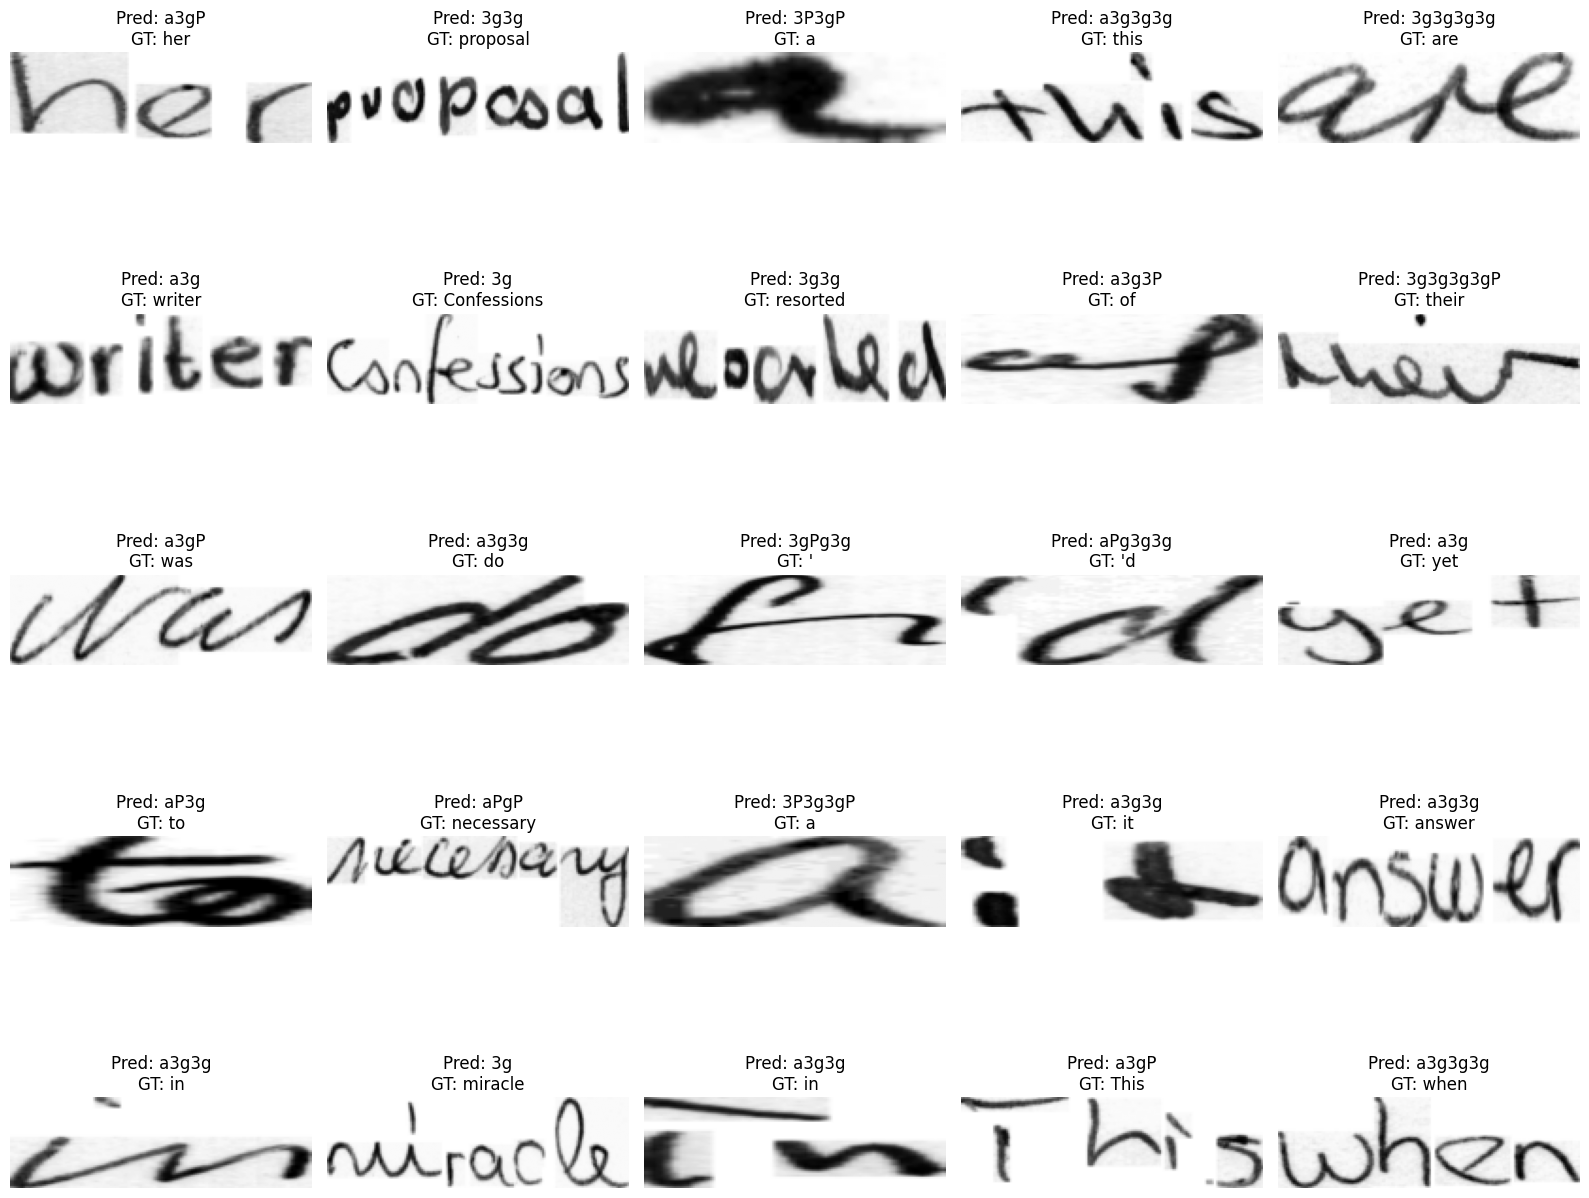

In [17]:
# Show random 25 predictions from the test set (with ground truth)
num_samples = min(25, len(test_ds))
rand_indices = random.sample(range(len(test_ds)), k=num_samples)

imgs, labels = [], []
for idx in rand_indices:
    img, target = test_ds[idx]  # val_tf already applied in dataset
    imgs.append(img)
    labels.append("".join(idx_to_char[int(c)] for c in target if int(c) != PAD_TOKEN and int(c) != BLANK_TOKEN))
images = torch.stack(imgs).to(DEVICE)

model.eval()
with torch.no_grad():
    log_probs = model(images)
    T = log_probs.size(1)
    input_lengths = torch.full(size=(images.size(0),), fill_value=T, dtype=torch.long, device=DEVICE)
    preds_text = greedy_decode(log_probs, input_lengths)

images_np = images.cpu() * 0.5 + 0.5
images_np = images_np.numpy()

rows = math.ceil(num_samples / 5)
cols = min(5, num_samples)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 2.8))
axes = axes.flatten()
for i in range(num_samples):
    img = images_np[i, 0]
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {preds_text[i]}\nGT: {labels[i]}")
for j in range(num_samples, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()



In [ ]:
# One-cell inference: load best checkpoint and visualize 25 random test samples
best_path = Path("checkpoints/htr_model_best.pt")
latest_path = Path("checkpoints/htr_model_latest.pt")
load_path = best_path if best_path.exists() else latest_path
assert load_path.exists(), f"Checkpoint not found at {best_path} or {latest_path}. Train or save first."

loaded_model, checkpoint = load_model(load_path, DEVICE)
model = loaded_model.eval()

num_samples = min(25, len(test_ds))
rand_indices = random.sample(range(len(test_ds)), k=num_samples)

imgs, labels = [], []
for idx in rand_indices:
    img, target = test_ds[idx]  # val_tf already applied in dataset
    imgs.append(img)
    labels.append("".join(idx_to_char[int(c)] for c in target if int(c) != PAD_TOKEN and int(c) != BLANK_TOKEN))
images = torch.stack(imgs).to(DEVICE)

with torch.no_grad():
    log_probs = model(images)
    T = log_probs.size(1)
    input_lengths = torch.full(size=(images.size(0),), fill_value=T, dtype=torch.long, device=DEVICE)
    preds_text = greedy_decode(log_probs, input_lengths)

images_np = images.cpu() * 0.5 + 0.5
images_np = images_np.numpy()

rows = math.ceil(num_samples / 5)
cols = min(5, num_samples)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 2.8))
axes = axes.flatten()
for i in range(num_samples):
    img = images_np[i, 0]
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {preds_text[i]}\nGT: {labels[i]}")
for j in range(num_samples, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()



## Save model locally


In [49]:
# Save the best model with all metadata
if 'best' in locals() and best['cer'] < float('inf'):
    best_path, latest_path = save_model_complete(
        model, optimizer, best['epoch'], best['cer'], 
        save_dir="checkpoints", 
        model_name="htr_model"
    )
    print(f"\nModel files saved:")
    print(f"  Best model: {best_path}")
    print(f"  Latest model: {latest_path}")
    print(f"\nTo load the model later, use:")
    print(f"  loaded_model, checkpoint = load_model('{best_path}', DEVICE)")
else:
    print("No trained model found. Train the model first.")



Model saved to: checkpoints/htr_model_best.pt

Model files saved:
  Best model: checkpoints/htr_model_best.pt
  Latest model: checkpoints/htr_model_latest.pt

To load the model later, use:
  loaded_model, checkpoint = load_model('checkpoints/htr_model_best.pt', DEVICE)


## Predict a custom image


In [50]:
def predict_custom_image(image_path, model, transform, device):
    """Predict text from a custom image using greedy decoding."""
    image_path = Path(image_path)
    if not image_path.exists():
        print(f"Image not found at {image_path}")
        return None
    
    img = Image.open(image_path)
    img_tensor = transform(img)
    img_batch = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        log_probs = model(img_batch)
        T_steps = log_probs.size(1)
        input_lengths = torch.tensor([T_steps], dtype=torch.long, device=device)
        preds = greedy_decode(log_probs, input_lengths)
        prediction = preds[0]

    plt.figure(figsize=(4, 2))
    display_img = img_tensor.squeeze(0).cpu().numpy() * 0.5 + 0.5
    plt.imshow(display_img, cmap="gray")
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")
    plt.show()
    
    return prediction

# Example: predict_custom_image("path/to/my_word.png", model, val_tf, DEVICE)

